In [6]:
import pandas as pd
import re
import tensorflow as tf
import sklearn
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding, SpatialDropout1D
import matplotlib.pyplot as plt
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# LSTM RNN


<img src="./lstm.png" alt="Alternative text" />

LSTM долають проблеми зникаючих градієнтів і вибухових градієнтів, характерних для RNN. Вони містять спеціальні одиниці, відомі як ***клітини***. Кожна клітина містить одну або більше одиниць пам'яті та три оборотні елементи. Вони називаються ***воротами*** клітин.

Працює це таким чином:

*  **Вхід** - Це ворота читання. Вони отримують відповідні вхідні дані, щоб дозволити коригувати вагові коефіцієнти в певному вузлі.
*  **Вихід** - Це ворота запису. Це дозволяє інформації в комірці регулювати ваги певного вузла на основі релевантності інформації всередині.
*  **Скидання (Reset)** - Це ворота забуття. Вони позбавляються інформації в клітинці, яка більше не потрібна.

Блоки пам'яті можна назвати ***воротами запам'ятовування (remember gate)***. Це дозволяє мережі LSTM зберігати інформацію. Блоки пам’яті – це те, що забезпечує здатність нейронної мережі LSTM довгостроково відновлювати дані.

### Завантаження даних

Завантажимо набір даних у змінну та отримаємо необхідні стовпці. У цьому випадку 'Consumer complaint narrative' та 'Product'. Нарешті, ми видаляємо нульові значення.

In [7]:
complaints = pd.read_csv("complaints.csv", nrows=1000)
complaints.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-01-23,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,33993,NaN,Consent not provided,Web,2023-02-13,Closed with non-monetary relief,Yes,NaN,6473143
1,2022-06-08,Debt collection,Mortgage debt,Attempts to collect debt not owed,Debt was paid,NaN,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",NV,89131,NaN,Consent not provided,Web,2022-06-08,Closed with explanation,Yes,NaN,5647636
2,2023-05-18,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,NaN,NaN,"EQUIFAX, INC.",WI,53209,NaN,NaN,Web,2023-05-18,In progress,Yes,NaN,6994349
3,2023-05-13,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,NaN,NaN,Experian Information Solutions Inc.,NY,10469,NaN,NaN,Web,2023-05-13,In progress,Yes,NaN,6972527
4,2023-05-12,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,Experian Information Solutions Inc.,CA,922XX,NaN,NaN,Web,2023-05-12,In progress,Yes,NaN,6970706


In [8]:
complaints = complaints[['Consumer complaint narrative','Product']]
complaints.dropna(inplace=True)
complaints.reset_index(drop=True, inplace=True)
complaints

,Consumer complaint narrative,Product
0,My name is XXXX XXXX XXXX this complaint is no...,"Credit reporting, credit repair services, or o..."
1,"When I reviewed my credit report, I discovered...","Credit reporting, credit repair services, or o..."
2,I am writing to file a complaint with the Cons...,"Credit reporting, credit repair services, or o..."
3,I'm really not sure what happened. I have mail...,"Credit reporting, credit repair services, or o..."
4,I recently received a copy of my credit report...,"Credit reporting, credit repair services, or o..."
5,"Hello, I would like to know what inconstancy '...","Credit reporting, credit repair services, or o..."
6,I'm really not sure what happened. I have mail...,"Credit reporting, credit repair services, or o..."
7,While I was with wells Fargo they would overch...,Checking or savings account
8,Between entering into a real estate transactio...,"Money transfer, virtual currency, or money ser..."
9,This is a medical debt on my credit report and...,Debt collection


### Очищення даних

Нам потрібно видалити непотрібні символи з текстових даних. symbols_regex містить список символів, які потрібно замінити пробілом. bad_symbols_regex містить регулярний вираз для цифр та інших символів у поєднанні з текстовими даними, тому його потрібно видалити без додавання пробілу.

In [10]:
symbols_regex = re.compile('[/(){}\[\]\|@,;]')
bad_symbols_regex = re.compile('[^0-9a-z #+_]')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub('\d+', '', text)
    text = text.lower()
    text = symbols_regex.sub(' ', text)
    text = bad_symbols_regex.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

complaints['Consumer complaint narrative'] = complaints['Consumer complaint narrative'].apply(clean_text)

### Дослідження label-ів

Переглянемо кількість скарг у кожній категорії.

In [11]:
complaints['Product'].value_counts().sort_values(ascending=False)

Product
Credit reporting, credit repair services, or other personal consumer reports    34
Checking or savings account                                                      4
Student loan                                                                     3
Debt collection                                                                  2
Money transfer, virtual currency, or money service                               1
Credit card or prepaid card                                                      1
Vehicle loan or lease                                                            1
Mortgage                                                                         1
Name: count, dtype: int64

### Векторизація тексту

Розділимо речення на окремі слова. Встановимо максимальну кількість слів, які використовує TextVectorizer, використовуючи параметр max_tokens.

In [12]:
vectorize_layer = tf.keras.layers.TextVectorization(standardize='lower_and_strip_punctuation', max_tokens=500, output_mode='int', output_sequence_length=256)
vectorize_layer.adapt(complaints['Consumer complaint narrative'])

X_train_padded = vectorize_layer(complaints['Consumer complaint narrative']).numpy()

Далі ми перетворюємо текст на послідовності, а потім доповнюємо послідовності, щоб переконатися, що всі послідовності скинуто до 512.

Оскільки нейронна мережа може мати лише числа як вхідні дані, ми використовуємо LabelEncoder для перетворення цільових даних у числа.

In [13]:
le = sklearn.preprocessing.LabelEncoder()
complaints['Product'] = le.fit_transform(complaints['Product'])
y = complaints['Product']

Далі розділимо набір даних на тренувальну та тестувальну вибірку. Набір даних тестування становить 25 відсотків. random_state встановлено на 42, щоб уникнути суперечливих результатів під час кожного навчання. Це запобігає витоку даних, коли частина нашого тестового набору даних використовується для навчання.

In [14]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_train_padded, y, test_size=0.25, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(35, 256) (35,)
(12, 256) (12,)


### Створення LSTM мережі

Embedding шар представляє токени як щільний вектор. Позиція слова у векторному просторі залежить від слів, які його оточують. Таким чином ми надаємо значення слову залежно від контексту, у якому воно вживається.

Ми використовуємо функцію активації softmax, оскільки це проблема багатокласового маркування.

In [15]:
classifier = Sequential()
classifier.add(Embedding(5000, 100, input_length=X_train_padded.shape[1]))
classifier.add(SpatialDropout1D(0.2))
classifier.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
classifier.add(Dense(len(le.classes_), activation='softmax'))

In [16]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

### Тренування моделі LSTM

In [32]:
optimizer = keras.optimizers.Adam(lr=0.001)
classifier.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = classifier.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.9570 - accuracy: 0.7714 - val_loss: 1.7040 - val_accuracy: 0.5833
Epoch 2/10
1/1 [==============================] - 1s 742ms/step - loss: 0.9349 - accuracy: 0.7714 - val_loss: 1.6971 - val_accuracy: 0.5833
Epoch 3/10
1/1 [==============================] - 1s 805ms/step - loss: 0.9242 - accuracy: 0.7714 - val_loss: 1.6946 - val_accuracy: 0.5833
Epoch 4/10
1/1 [==============================] - 1s 859ms/step - loss: 0.9068 - accuracy: 0.7714 - val_loss: 1.7214 - val_accuracy: 0.5833
Epoch 5/10
1/1 [==============================] - 1s 834ms/step - loss: 0.8799 - accuracy: 0.7714 - val_loss: 1.7603 - val_accuracy: 0.5833
Epoch 6/10
1/1 [==============================] - 1s 834ms/step - loss: 0.8624 - accuracy: 0.7714 - val_loss: 1.2175 - val_accuracy: 0.5833
Epoch 7/10
1/1 [==============================] - 1s 833ms/step - loss: 1.2344 - accuracy: 0.6857 - val_loss: 1.8122 - val_accuracy: 0.5833
Epoch 8/10
1/1 [=======

### Оцінка моделі LSTM

In [33]:
classifier.evaluate(X_test,y_test)

1/1 [==============================] - 0s 93ms/step - loss: 1.8534 - accuracy: 0.5833


[1.8533754348754883, 0.5833333134651184]

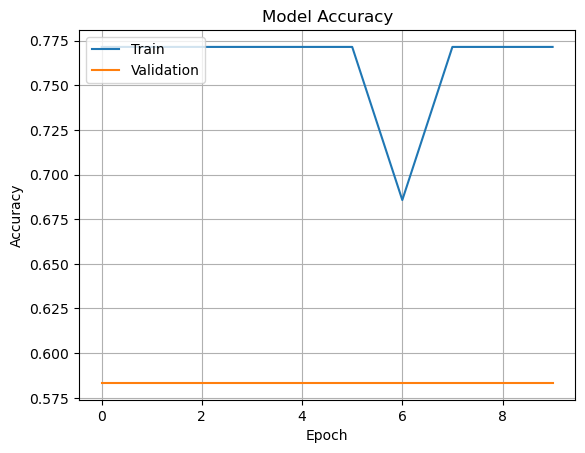

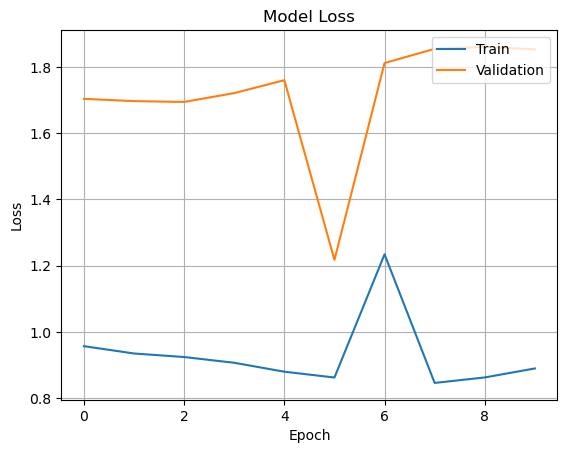

In [34]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()
